In [1]:
# """
# View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
# My Youtube Channel: https://www.youtube.com/user/MorvanZhou
# More about Reinforcement learning: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/
# Dependencies:
# torch: 0.4
# gym: 0.8.1
# numpy
# """

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt

In [3]:
seed = 161
# random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
# Hyper Parameters
BATCH_SIZE = 32
LR = 1e-3                  # learning rate
EPSILON = 0.95               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000

In [5]:
env = gym.make('CartPole-v0')
env = env.unwrapped
env.seed(seed);

In [6]:
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [7]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [8]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter = 0                                     # for target updating
        
        self.good_memory_counter = 0                                         # for storing memory
        self.good_memory = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2))     # initialize memory
        
        self.bad_memory_counter = 0                                         # for storing memory
        self.bad_memory = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2))     # initialize memory
        
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        if r > 0:
            # replace the old memory with new memory
            index = self.good_memory_counter % int(MEMORY_CAPACITY/2)
            self.good_memory[index, :] = transition
            self.good_memory_counter += 1
        
        else:
            # replace the old memory with new memory
            index = self.bad_memory_counter % int(MEMORY_CAPACITY/2)
            self.bad_memory[index, :] = transition
            self.bad_memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(MEMORY_CAPACITY/2), int(BATCH_SIZE-6))
        bad_sample_index  = np.random.choice(int(MEMORY_CAPACITY/2), int(6))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory = self.bad_memory[bad_sample_index, :]
        b_memory = np.vstack((b_good_memory,b_bad_memory))
        
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [9]:
dqn = DQN()
NO_OF_EPISODES = int(MEMORY_CAPACITY/2) + 1000

In [10]:
print('\nCollecting experience...')
ep_r_rec = []
time_rec = []
flag = True
learn_start = 0
for i_episode in range(NO_OF_EPISODES):
       
    s = env.reset()
    ep_r = 0
    time_steps = 0
    while True:
#         env.render()
        time_steps += 1
        a = dqn.choose_action(s)

        # take action
        s_, r, done, info = env.step(a)
        
        if done:
            r = -1
            
        dqn.store_transition(s, a, r, s_)
        ep_r += r
        if dqn.good_memory_counter > MEMORY_CAPACITY/2 and dqn.bad_memory_counter > MEMORY_CAPACITY/2:
            dqn.learn()
            if flag:
                print("Learning starts from EPISODE: ",i_episode)
                learn_start = i_episode
                flag = False

        if done:
            ep_r_rec = np.append(ep_r_rec, ep_r)
            time_rec = np.append(time_rec, time_steps)
            if time_steps > 1000:
                print('EPISODE: {:4d}  |  REWARD: {:10.3f}  | TIME_STEPS: {:5d} | LR: {:3.2e} | EPSILON: {:3.2f} '.format(i_episode, ep_r, time_steps, LR, EPSILON))
            
            break
        s = s_


Learning starts from EPISODE:  1000
EPISODE: 1592  |  REWARD: 165144.000  | TIME_STEPS: 165146 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1593  |  REWARD:   6461.000  | TIME_STEPS:  6463 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1600  |  REWARD:  22735.000  | TIME_STEPS: 22737 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1601  |  REWARD:   4218.000  | TIME_STEPS:  4220 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1602  |  REWARD:   1053.000  | TIME_STEPS:  1055 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1952  |  REWARD:  69625.000  | TIME_STEPS: 69627 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1953  |  REWARD:  19668.000  | TIME_STEPS: 19670 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1955  |  REWARD:  11562.000  | TIME_STEPS: 11564 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1958  |  REWARD:  50229.000  | TIME_STEPS: 50231 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1960  |  REWARD:   3756.000  | TIME_STEPS:  3758 | LR: 1.00e-03 | EPSILON: 0.95 
EPISODE: 1963  |  REWARD:   1575.000  | TIME_STEPS:  1577 | LR

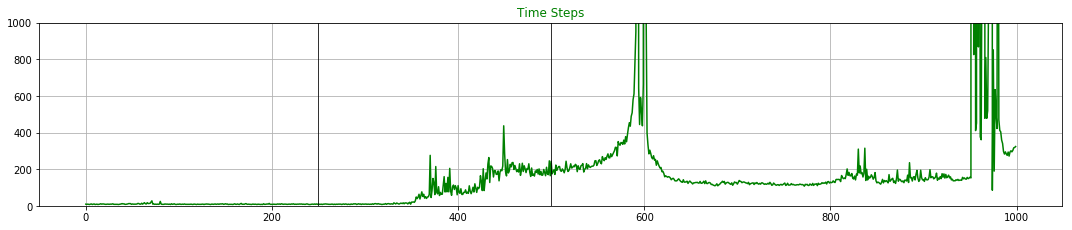

In [20]:
fig = plt.figure(figsize = (15,6))

ax2 = fig.add_subplot(2, 1, 1)
data = time_rec[learn_start:]
ax2.plot(data, color = 'g')
ax2.plot(np.ones_like(data)*1500, 'g--')

ax2.set_title('Time Steps',color = 'g')
for xpt in [250,500]:
    ax2.axvline(x=xpt,color='k',linewidth='0.8')
# ax2.set_yscale('log')
ax2.set_ylim([1,1e3])
fig.tight_layout()
ax2.grid()

plt.show()

In [15]:
data.mean()

620.818

In [12]:
env.close()

In [13]:
# s = env.reset()
# while True:
#     env.render()
#     a = dqn.choose_greedy_action(s)
#     s_, r, done, info = env.step(a)
#     if done:
#         break
#     s = s_

In [14]:
# env.close()